In [1]:
%run my_imports.py

# Figure on jupyter notebook
%matplotlib inline

# Automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
folder_selected = r'D:\DataSet\MySpaces\data'
df_events = loading_from_listfolder(folder_selected,'df_events_ACTION')
folderGA = os.path.join(folder_selected,'GA')

if not os.path.exists(folderGA):
    os.makedirs(folderGA)
    print('**** Create Grand Average folder ****')
else:
    print('**** Grand Average folder exists already ****')
    
print('Number of subjects found: ' + str(len(df_events)))

D:\DataSet\MySpaces\data\s01
D:\DataSet\MySpaces\data\s02
D:\DataSet\MySpaces\data\s03
D:\DataSet\MySpaces\data\s04
D:\DataSet\MySpaces\data\s05
D:\DataSet\MySpaces\data\s06
D:\DataSet\MySpaces\data\s07
D:\DataSet\MySpaces\data\s08
D:\DataSet\MySpaces\data\s09
D:\DataSet\MySpaces\data\s10
D:\DataSet\MySpaces\data\s12
D:\DataSet\MySpaces\data\s13
D:\DataSet\MySpaces\data\s14
D:\DataSet\MySpaces\data\s15
**** Grand Average folder exists already ****
Number of subjects found: 14


# Phase coupling analysis

In [3]:
nbins = 7
bins = np.linspace(-np.pi, np.pi, nbins)
bins = np.rad2deg(bins);
diff_bins = np.round(bins[1] - bins[0])
print(int(diff_bins))
print(bins)

60
[-180. -120.  -60.    0.   60.  120.  180.]


In [4]:
GA_df_events = dict()
list_subjects_events = []
nSubjects = len(df_events)
for iEvent,event_type in enumerate(df_events[0].keys()):
    print(event_type)
    list_subjects_events = []
    list_subjects_events_conca = []
    for iSubject in range(nSubjects):
        df_events[iSubject][event_type]['subjectID'] = iSubject
        df_events[iSubject][event_type]['group'] = df_events[iSubject][event_type]['group']*int(diff_bins)
        df_events[iSubject][event_type] = df_events[iSubject][event_type]
        list_subjects_events.append(df_events[iSubject][event_type])
    list_subjects_events_conca = pd.concat(list_subjects_events)
    GA_df_events.update({event_type:list_subjects_events_conca})

Mu_ST_ACTION_SELF
Mu_ST_ACTION_CUE
Beta_ST_ACTION_SELF
Beta_ST_ACTION_CUE


Mu_ST_ACTION_SELF
Mu_ST_ACTION_CUE
Beta_ST_ACTION_SELF
Beta_ST_ACTION_CUE


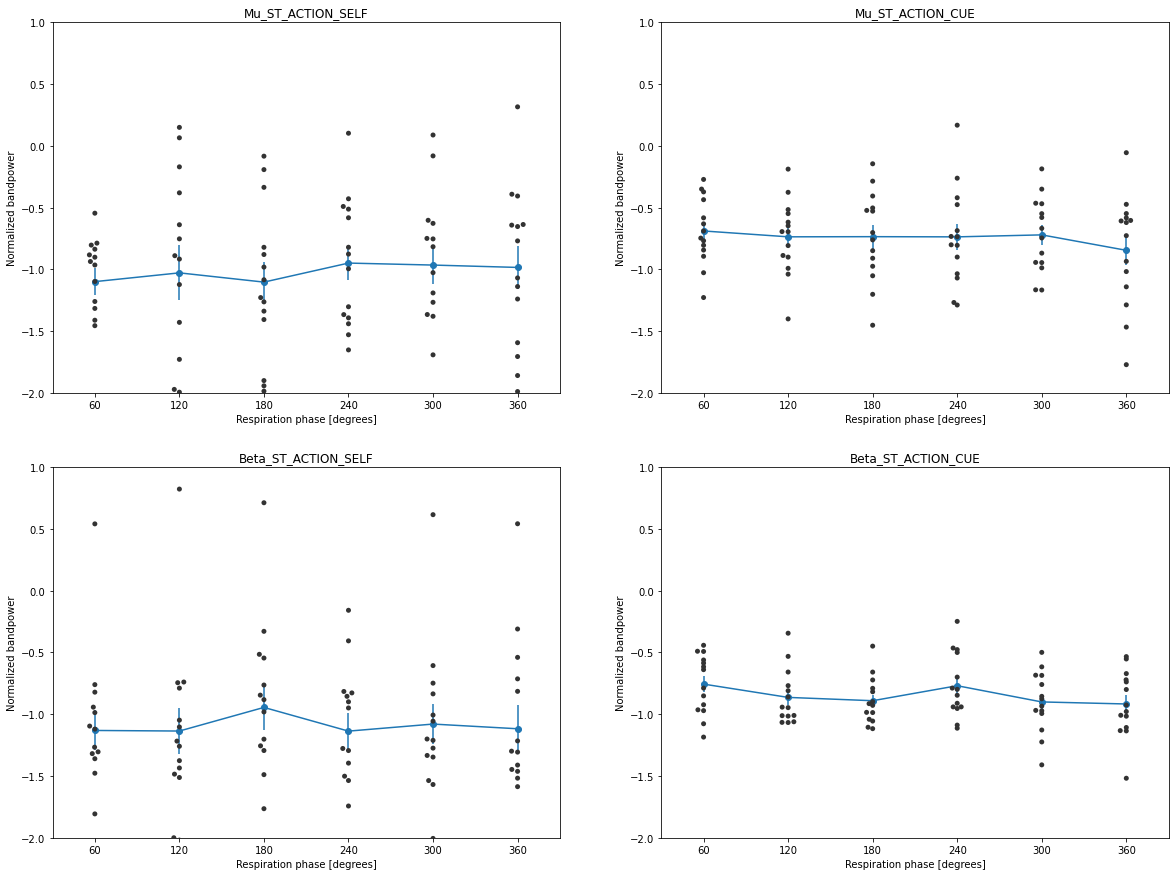

In [5]:
listInterest = ['Mu_ST_ACTION_SELF',
'Mu_ST_ACTION_CUE',
'Beta_ST_ACTION_SELF',
'Beta_ST_ACTION_CUE']


import seaborn as sns
import pandas as pd
import matplotlib.ticker as tck

fig = plt.figure(figsize=(20,15))    
df_new = pd.DataFrame()

for iEvent,event_type in enumerate(listInterest):
    print(event_type)
    df = GA_df_events[event_type]
    df_new = df.groupby(['group','subjectID']).mean().reset_index()
    
    mean = df_new.groupby(['group']).mean().reset_index()
    dev = df_new.groupby(['group']).sem().reset_index()
    x = mean['Power'].to_numpy()
    yerr = dev['Power'].to_numpy()

    axs=fig.add_subplot(221+iEvent)
    axs = sns.swarmplot(x="group", y="Power", data=df_new, color="0.2")
    axs.errorbar(np.arange(nbins),x, yerr=yerr, fmt='-o') #fmt=None to plot bars only
    

    axs.set_title(event_type,y=1)
    axs.set_xlabel("Respiration phase [degrees]")
    axs.set_ylabel("Normalized bandpower")
    axs.set_xlim([-125,185])
    axs.set_xlim([0.5,6.5])
    axs.set_ylim([-2,1])

path = os.path.join(folderGA,'Phase_coupling_bandpower_1')
saving_figure('BandPower_values',path,fig)

In [9]:
GA_MI = dict()
data_original = []
for iEvent,event_type in enumerate(listInterest):
    print(event_type)
    df = GA_df_events[event_type]
    df_new = df.copy().dropna()
    df2 = df_new.groupby(['group','subjectID']).mean().reset_index()
    data_av = df2.to_numpy() 
    data_2d = transform_dataframe_2d(data_av)
    MI_real = np.zeros((nSubjects))
    for iSubject in range(nSubjects):
        thisDataSubject = data_2d[iSubject,:]
        MI_real[iSubject] = compute_modulation_index(thisDataSubject)
    GA_MI.update({event_type:np.mean(MI_real)})
    print('GA_MI =' + str(GA_MI[event_type]))
    del df_new, df

Mu_ST_ACTION_SELF
GA_MI =0.22632636692169003
Mu_ST_ACTION_CUE
GA_MI =0.24340697242015202
Beta_ST_ACTION_SELF
GA_MI =0.23717518820461464
Beta_ST_ACTION_CUE
GA_MI =0.22865173900962005


In [11]:
GA_MI_surrogate_event = dict()
nPermutation = 1000
df_new = []

for iEvent,event_type in enumerate(listInterest):
    print(event_type)
    df = GA_df_events[event_type]
    df_new = df.copy().dropna()
    GA_MI_surrogate = np.zeros(nPermutation)
    for iPermutation in range(nPermutation):
        MI_surrogate = np.zeros((nSubjects))
        for iSubject in range(nSubjects):
            df_subject = df_new.copy()
            df_subject = df_subject[(df_subject["subjectID"] == iSubject)]  
            data_original = df_new.to_numpy()[:,0:2]
            nsamples = np.shape(data_original)[0]
            perm = np.random.permutation(nsamples)
            data_surrogate = data_original
            data_surrogate[:,1] = data_original[perm,1]  
            perm_data = pd.DataFrame(data_surrogate,columns=['group','Power'])
            data_surrogate = perm_data.groupby(['group']).mean().reset_index().to_numpy()[:,1]
            MI_surrogate[iSubject] = compute_modulation_index(data_surrogate)
            del df_subject
        GA_MI_surrogate[iPermutation] = np.mean(MI_surrogate)
    GA_MI_surrogate_event.update({event_type:GA_MI_surrogate})
    index = GA_MI_surrogate_event[event_type] > GA_MI[event_type]
    pval = 1-np.sum(index)/float(nPermutation)
    print(pval)
    axs.set_title(event_type + " " + "pval = " + str(pval))
print('Finished')

Mu_ST_ACTION_SELF
0.041000000000000036
Mu_ST_ACTION_CUE
0.31000000000000005
Beta_ST_ACTION_SELF
0.17500000000000004
Beta_ST_ACTION_CUE
0.07499999999999996
Finished


Mu_HOLD
0.544
Mu_MI_START
0.371
Beta_HOLD
0.5900000000000001
Beta_MI_START
0.473


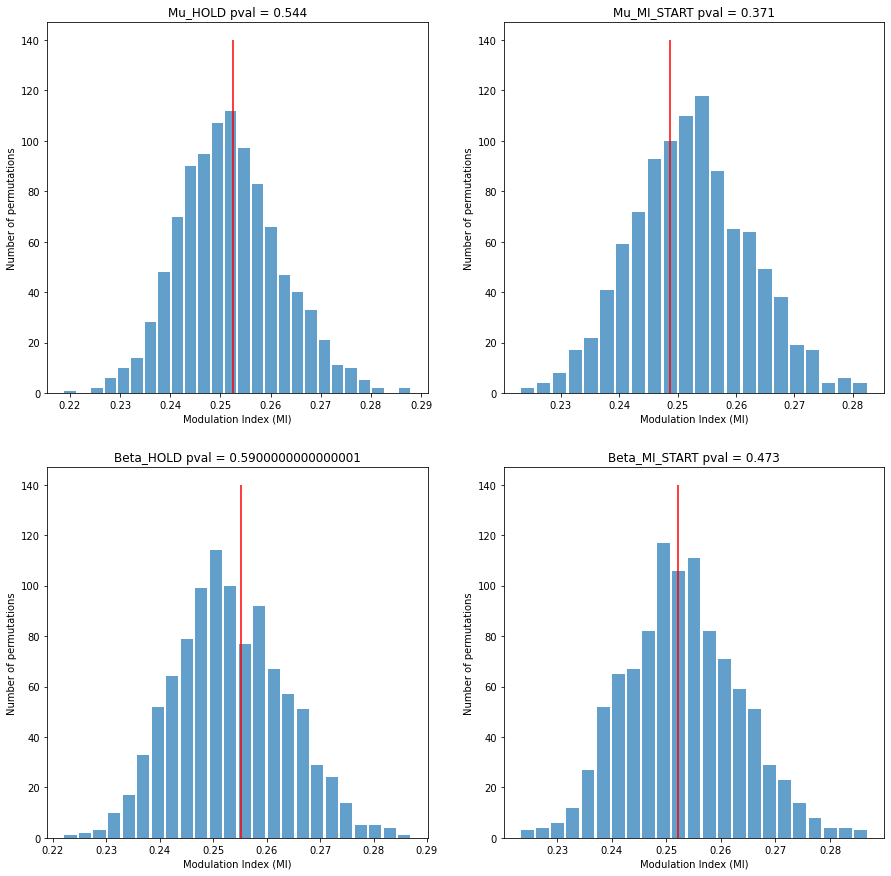

In [20]:
listInterest
fig = plt.figure(figsize=(15,15))   
for iEvent,event_type in enumerate(listInterest):
    print(event_type)
    axs=fig.add_subplot(221+iEvent)
    axs.hist(x=GA_MI_surrogate_event[event_type], bins='auto',alpha=0.7, rwidth=0.85)
    axs.set_xlabel('Modulation Index (MI)')
    axs.set_ylabel('Number of permutations') 
    axs.set_title('Histogram')
    axs.vlines(GA_MI[event_type],0, 140, colors='r')
    #axs.set_xlim([-1,3]) 
    index = GA_MI_surrogate_event[event_type] > GA_MI[event_type]
    pval = np.sum(index)/float(nPermutation)
    print(pval)
    axs.set_title(event_type + " " + "pval = " + str(pval))
plt.show()


path = os.path.join(folderGA,'Phase_coupling_bandpower_last_last1330')
# saving_figure('BandPower_Permutation',path,fig)
